# **실습 문제**
* 10개의 이미지를 분류하는 문제
* 과적합 방지 기법 2가지 적용
* 랜덤 서치를 이용하여 하이퍼 파라미터 튜닝 수행
* 하이퍼 파라미터의 개수는 최소 3개 이상 적용

In [1]:
import os
import random
import shutil
from sklearn.model_selection import train_test_split
import imgaug.augmenters as iaa
from PIL import Image
import os
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from PIL import Image

2024-12-16 06:21:19.787010: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-16 06:21:19.813292: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-16 06:21:20.220085: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### **0. 데이터 준비**
* Cifar10 Dataset
* 10개의 클래스(비행기, 자동차, 새, 고양이, 사슴, 개, 개구리, 말, 배, 트럭)으로 구성된 32x32 픽셀의 컬러 이미지 데이터셋

### **1. 데이터셋 경로 설정**

In [18]:
# 1. 데이터셋 경로 설정
original_data_dir = "cifar10_images" 
output_base_dir = "cifar10_dataset"
train_dir = os.path.join(output_base_dir, "train")
valid_dir = os.path.join(output_base_dir, "valid")
test_dir = os.path.join(output_base_dir, "test")

### **2. 데이터셋 분할: 0.7 (Train), 0.2 (Validation), 0.1 (Test)**

In [19]:
def split_data(original_dir, train_ratio=0.7, valid_ratio=0.2):
    # 클래스별 데이터를 나눔
    class_dirs = [os.path.join(original_dir, class_name) for class_name in os.listdir(original_dir)]
    for class_dir in class_dirs:
        if not os.path.isdir(class_dir):
            continue

        # 각 클래스의 이미지 경로
        images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith(('.png', '.jpg'))]
        random.shuffle(images)

        # 분할
        train_split = int(len(images) * train_ratio)
        valid_split = int(len(images) * (train_ratio + valid_ratio))

        train_images = images[:train_split]
        valid_images = images[train_split:valid_split]
        test_images = images[valid_split:]

        # 데이터를 출력 디렉토리에 저장
        for output_dir, image_set in zip([train_dir, valid_dir, test_dir], [train_images, valid_images, test_images]):
            class_output_dir = os.path.join(output_dir, os.path.basename(class_dir))
            os.makedirs(class_output_dir, exist_ok=True)
            for image_path in image_set:
                shutil.copy(image_path, class_output_dir)

split_data(original_data_dir)

### **3. Data 전처리**

In [23]:
import os
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
# 데이터 로드 함수 수정
def load_data(data_dir, image_size=(32, 32)):
    images = []
    labels = []
    
    # 디렉토리 구조 탐색
    for class_name in sorted(os.listdir(data_dir)):  # 클래스는 디렉토리 이름
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):  # 디렉토리가 아니면 건너뜀
            continue
        
        # 각 클래스의 이미지 탐색
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            if img_path.endswith(('.png', '.jpg', '.jpeg')):  # 이미지 파일만 처리
                # 이미지 로드 및 전처리
                img = Image.open(img_path).convert('RGB')  # RGB 변환
                img = img.resize(image_size)  # 크기 조정
                img = np.array(img) / 255.0  # 정규화 (0~1)
                images.append(img)  # (32, 32, 3) 유지
                labels.append(class_name)  # 라벨 추가
    
    # NumPy 배열로 변환
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels)
    
    # 라벨을 원-핫 인코딩
    lb = LabelEncoder()
    labels = lb.fit_transform(labels)
    
    return images, labels


In [24]:
# 데이터 로드
X_train, y_train = load_data(train_dir)
X_valid, y_valid = load_data(valid_dir)
X_test, y_test = load_data(test_dir)

In [25]:
print(X_train.shape)

(4569, 32, 32, 3)


In [26]:
# CNN 모델 정의 함수 수정
def build_cnn_model(input_shape=(32, 32, 3), num_classes=10):
    model = Sequential()

    # 첫 번째 Convolutional Layer
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 두 번째 Convolutional Layer
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten Layer
    model.add(Flatten())

    # Fully Connected Layer
    model.add(Dense(units=128, activation='relu'))

    # Output Layer
    model.add(Dense(units=num_classes, activation='softmax'))

    # 모델 컴파일
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy']
    )

    return model



In [15]:
# CNN 모델 학습 및 평가 함수 수정
def train_and_evaluate_cnn_model(X_train, y_train, X_valid, y_valid, X_test, y_test, model, epochs, description):
    print(f"\nTraining with {description} data...\n")

    # 모델 학습
    history = model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        epochs=epochs,
        batch_size=32,  # CIFAR-10에 맞게 배치 크기 조정
        verbose=1
    )

    # Test 데이터 성능 평가
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"\nTest Accuracy ({description}): {test_accuracy * 100:.2f}%\n")
    return history

In [16]:
import matplotlib.pyplot as plt

def plot_training_history(history, description):
    # 학습 및 검증 손실 곡선
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{description} - Loss')
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 학습 및 검증 정확도 곡선
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{description} - Accuracy')
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


Training with CIFAR-10 CNN Model data...

Epoch 1/10


2024-12-16 06:22:17.228503: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-16 06:22:17.244914: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-16 06:22:17.245059: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

110/110 [==============================] - 2s 6ms/step - loss: 2.0904 - accuracy: 0.2154 - val_loss: 1.7950 - val_accuracy: 0.3768
Epoch 2/10
110/110 [==============================] - 0s 4ms/step - loss: 1.6902 - accuracy: 0.3877 - val_loss: 1.6389 - val_accuracy: 0.4081
Epoch 3/10
110/110 [==============================] - 0s 4ms/step - loss: 1.5120 - accuracy: 0.4566 - val_loss: 1.6169 - val_accuracy: 0.4212
Epoch 4/10
110/110 [==============================] - 0s 3ms/step - loss: 1.3861 - accuracy: 0.5129 - val_loss: 1.4770 - val_accuracy: 0.4687
Epoch 5/10
110/110 [==============================] - 0s 4ms/step - loss: 1.2509 - accuracy: 0.5551 - val_loss: 1.4509 - val_accuracy: 0.4899
Epoch 6/10
110/110 [==============================] - 0s 3ms/step - loss: 1.1539 - accuracy: 0.6017 - val_loss: 1.4729 - val_accuracy: 0.4909
Epoch 7/10
110/110 [==============================] - 1s 5ms/step - loss: 1.0466 - accuracy: 0.6249 - val_loss: 1.5463 - val_accuracy: 0.4798
Epoch 8/10
110/11

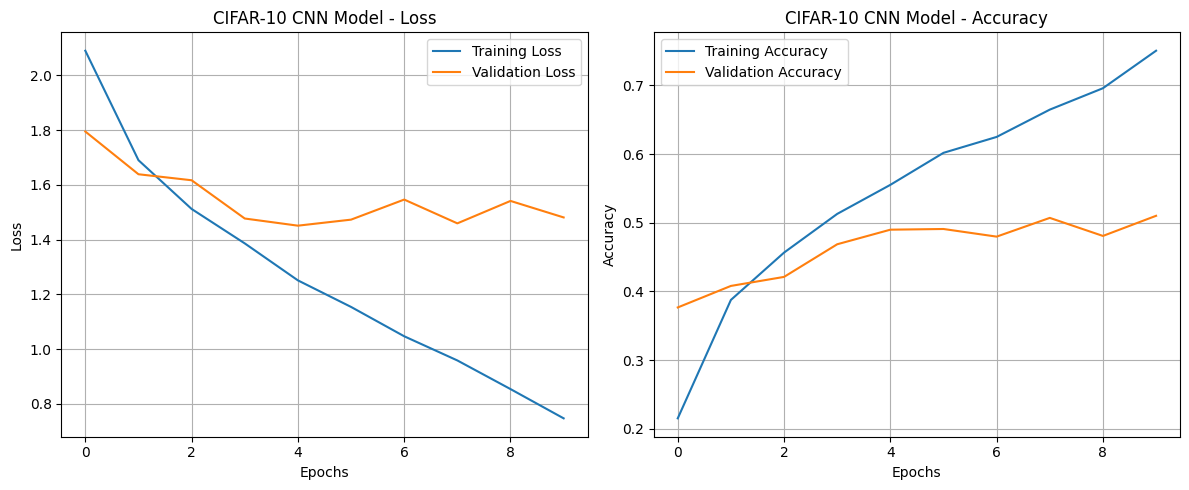

In [17]:
# 데이터 로드
X_train, y_train = load_data(train_dir)
X_valid, y_valid = load_data(valid_dir)
X_test, y_test = load_data(test_dir)

# 모델 생성
model = build_cnn_model()

# 학습 및 평가
history = train_and_evaluate_cnn_model(X_train, y_train, X_valid, y_valid, X_test, y_test, model, epochs=10, description="CIFAR-10 CNN Model")

# 학습 곡선 시각화
plot_training_history(history, "CIFAR-10 CNN Model")

## **문제 1. 과적합 방지를 위한 기법을 2가지 이상 적용하고 학습해보세요**

## **문제 2.  BayesianOptimization을 수행하여 SGD,  SGD with Momentum,   AdaGrad, RMSProp, Adam에 대한 하이퍼 파라미터 튜닝을 수행하세요**